In [1]:
!pip install -qq transformers

# BERT (Bidirectional Encoder Representations from Transformers)

> * Bidirectional - to understand the text you're looking you'll have to look back (at the previous words) and forward (at the next words)
> * The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim). 
> * (Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv("../input/google-play-storeappreviews/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOG-nGuDe0w6if400pTvNJnK3MlfnEcJLIB84aR...,Ben Maybe,https://play-lh.googleusercontent.com/a/AATXAJ...,But the paid version for a year and never succ...,1,25,5.15.4.2,2022-03-01 17:18:50,"Hi, we're sorry to hear you're experiencing is...",2022-03-01 15:53:58,most_relevant,com.anydo
1,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,67,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo
2,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,77,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo
3,gp:AOqpTOE3fQQpkWOMbSHW-DwukAnILBbMwBHEcbReiit...,Sydney Stoll,https://play-lh.googleusercontent.com/a/AATXAJ...,I have had this app for almost a year. I was r...,1,79,5.15.2.1,2021-11-07 15:58:27,This could happen if a user pressed on an adve...,2021-11-08 14:36:27,most_relevant,com.anydo
4,gp:AOqpTOG2AXuKqrR8FIN43a5BGZY4Iha5SFQZZ6o9vOR...,ChuCannon,https://play-lh.googleusercontent.com/a/AATXAJ...,"Works decently most of the time, but I've noti...",1,39,5.15.2.2,2021-11-18 17:05:38,"Hi, we're sorry to hear you're experiencing is...",2021-11-21 14:48:23,most_relevant,com.anydo


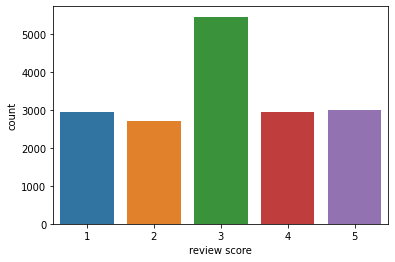

In [5]:
sns.countplot(df.score)
plt.xlabel('review score');

In [6]:
def sentiment(rating):
    if rating < 2:
        return 0
        
    if rating==3:
        return 1
        
    if rating > 3:
        return 2

df['sentiment'] = df.score.apply(sentiment)

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

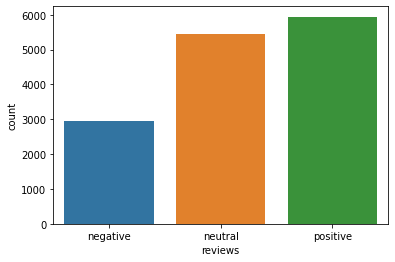

In [7]:
ax = sns.countplot(df.sentiment)
plt.xlabel('reviews')
ax.set_xticklabels(['negative', 'neutral', 'positive'])

# Tokenizing and Data Preprocessing

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [9]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

***one way***

In [10]:
# sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
# tokens = tokenizer.tokenize(sample_txt)
# token_ids = tokenizer.convert_tokens_to_ids
# print(f'Sentence: {sample_txt}\n')
# print(f'Tokens: {tokens}\n')
# print(f'Token IDs: {token_ids}')

[SEP] token has to be inserted at the end of a single input. When a task requires more than one input such as NLI and Q-A tasks, [SEP] token helps the model to understand the end of one input and the start of another input in the same sequence input.

In [11]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [12]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

The BERT model receives a fixed length of sentence as input. Usually the maximum length of a sentence depends on the data we are working on. For sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length. In the original implementation, the token [PAD] is used to represent paddings to the sentence.

In [13]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

***other way***

In [14]:
token_lens = []

for text in df.content:
    tokens = tokenizer.encode(text,max_length=128)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


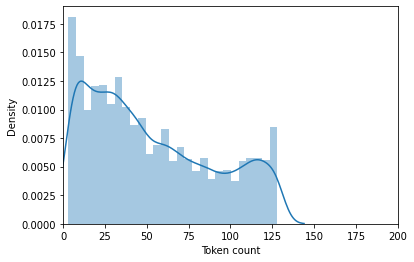

In [15]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

***and the other way***

In [16]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [17]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens = True, # [CLS] and [SEP]
    pad_to_max_length = True,
    return_token_type_ids = False,
    return_attention_mask = True,
    return_tensors = 'pt' # pt for pytorch 
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
# every input is now of size 32 and padded with 0
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

# Creating Dataset

In [20]:
class CustomDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        super().__init__()
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        review = self.reviews[item]
        target = self.targets[item]
        
        encoding = tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            add_special_tokens = True, 
            pad_to_max_length = True,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors = 'pt' 
        )
        
        return {
            'review': review,
            'target': torch.tensor(target,dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        

In [21]:
df.shape

(17082, 13)

In [22]:
df = df[df['sentiment'].notna()]


In [23]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2179
at                         0
replyContent            7059
repliedAt               7059
sortOrder                  0
appId                      0
sentiment                  0
dtype: int64

In [24]:
MAX_LEN = 160
BATCH_SIZE = 16
RANDOM_SEED = 2002
EPOCHS = 10

In [25]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [26]:
df_train.shape, df_val.shape, df_test.shape

((11491, 13), (1436, 13), (1437, 13))

In [27]:
ds = CustomDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
    )

# DataLoading

In [28]:
def Data_Loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
                ds,
                batch_size=batch_size,
                num_workers=4
             )

In [29]:
train_data_loader = Data_Loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = Data_Loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = Data_Loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [30]:
data = next(iter(train_data_loader))
print(data.keys())


dict_keys(['review', 'target', 'input_ids', 'attention_mask'])


In [31]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

***Lets try it on sample text***

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


***The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:***

In [33]:
last_hidden_state, pooled_output = bert_model(
                                        input_ids = encoding['input_ids'],
                                        attention_mask = encoding['attention_mask'],
                                        return_dict=False
                                    )

In [34]:
last_hidden_state.shape # 1 example , 32 elements after padding and 768 hidden units

torch.Size([1, 32, 768])

In [35]:
pooled_output.shape # pooling procedure on 32 elements

torch.Size([1, 768])

In [36]:
bert_model.config.hidden_size

768

# Building Sentiment Classifier

In [37]:
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
                                input_ids = input_ids,
                                attention_mask = attention_mask,
                                return_dict = False
                            )
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return self.softmax(output)

In [38]:
model = SentimentClassifier(n_classes = 3)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
optimizer = AdamW(model.parameters(),lr=2e-5,correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps = 0,
                num_training_steps = total_steps 
            )

loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_preds = 0
    
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['target'].to(device)
        
        outputs = model(input_ids,attention_mask)
        _, preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        correct_preds += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),max_norm=1.0) #  We're avoiding exploding gradients by clipping the gradients of the model using clip_gradnorm.
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_preds.double() / n_examples, np.mean(losses)

        

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_preds = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['target'].to(device)

            outputs = model(input_ids,attention_mask)
            _, preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            correct_preds += torch.sum(preds==targets)
            losses.append(loss.item())
            
    return correct_preds.double() / n_examples, np.mean(losses)


In [42]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_model(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print('\n')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
#         torch.save(model.state_dict(),'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8895378269472772 accuracy 0.6472891828387434
Val   loss 0.8509273495939043 accuracy 0.6908077994428969


Epoch 2/10
----------
Train loss 0.7862448751180328 accuracy 0.7575493864763728
Val   loss 0.816420171658198 accuracy 0.7325905292479109


Epoch 3/10
----------
Train loss 0.7348239190555249 accuracy 0.81341919763293
Val   loss 0.8232506129476759 accuracy 0.7249303621169917


Epoch 4/10
----------
Train loss 0.7103045571994383 accuracy 0.8397876599077538
Val   loss 0.808188118537267 accuracy 0.7437325905292479


Epoch 5/10
----------
Train loss 0.6937786942562905 accuracy 0.8571055608737272
Val   loss 0.7955854958958096 accuracy 0.7534818941504178


Epoch 6/10
----------
Train loss 0.6844588421979435 accuracy 0.8660690975546079
Val   loss 0.7986241181691488 accuracy 0.7534818941504178


Epoch 7/10
----------
Train loss 0.6769924323814137 accuracy 0.8735532155600034
Val   loss 0.7991188453303443 accuracy 0.7506963788300836


Epoch 8/10
----------
Tr

***Increase number of epochs to get better results***

In [43]:
train_acc = [acc.cpu() for acc in history['train_acc']]
val_acc = [acc.cpu() for acc in history['val_acc']]

(0.0, 1.0)

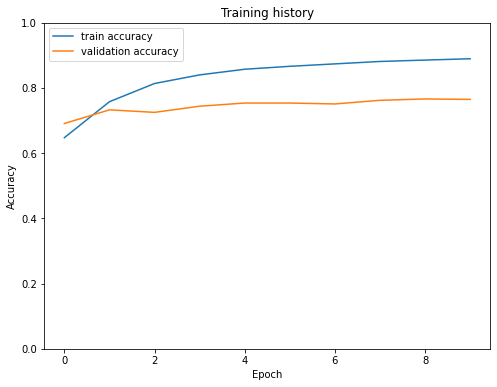

In [44]:
plt.figure(figsize = (8,6))
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [45]:
def get_preds(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['target'].to(device)
            
            review_texts.extend(reviews)
            real_values.extend(targets)
            
            outputs = model(input_ids,attention_mask)
            _, preds = torch.max(outputs,dim=1)
            
            prediction_probs.extend(outputs)
            predictions.extend(preds)
            
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
            
            
    return review_texts, predictions, prediction_probs, real_values
            

In [46]:
review_texts, predictions, prediction_probs, real_values = get_preds(model,test_data_loader)

In [47]:
class_names = ['negative','neutral','positive']

In [48]:
for i in range(3):
    print('review_texts: ',review_texts[i])
    print('predictions: ',class_names[predictions[i]])
    print('prediction_probs: ',prediction_probs[i])
    print('real_values: ',class_names[real_values[i]])
    print('\n')

review_texts:  Not bad
predictions:  neutral
prediction_probs:  tensor([2.4137e-05, 9.9993e-01, 4.2055e-05])
real_values:  neutral


review_texts:  Impossible for custom skills to influence multiple characteristics
predictions:  neutral
prediction_probs:  tensor([2.2660e-05, 9.9996e-01, 2.1047e-05])
real_values:  neutral


review_texts:  I just cannot be notified. Please. Fix it. So I could give 5 stars.
predictions:  negative
prediction_probs:  tensor([9.9994e-01, 1.9388e-05, 3.9770e-05])
real_values:  negative




In [49]:
print(classification_report(real_values, predictions, target_names=['negative','neutral','positive']))

              precision    recall  f1-score   support

    negative       0.79      0.72      0.75       299
     neutral       0.73      0.74      0.73       559
    positive       0.81      0.84      0.82       579

    accuracy                           0.77      1437
   macro avg       0.78      0.76      0.77      1437
weighted avg       0.77      0.77      0.77      1437



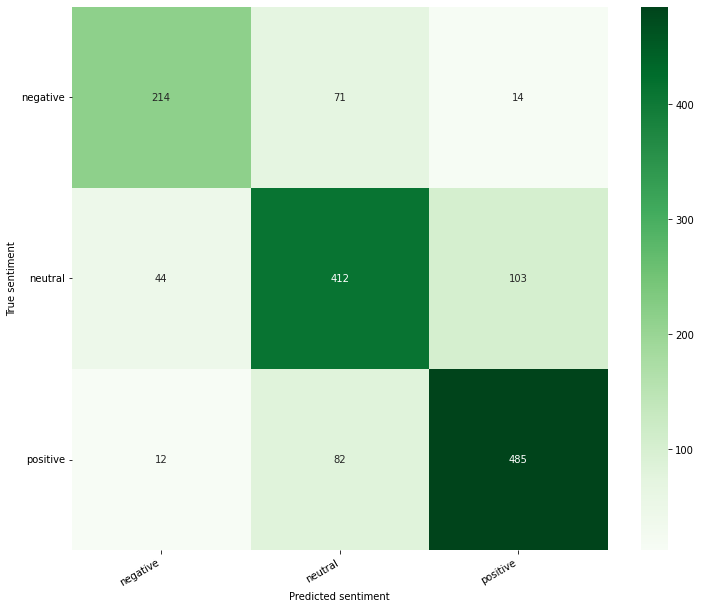

In [50]:
def show_confusion_matrix(confusion_matrix):
    plt.figure(figsize = (12,10))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(real_values, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Predicting new text sample

In [51]:
review_text = 'This notebook is very helpful.'

In [52]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [53]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: This notebook is very helpful.
Sentiment  : positive
